# PDE-FIND for Burger's Equation

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = 0.1u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import default_rng
import pandas as pd

import os
import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter, wiener
from scipy.integrate import trapz
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
# from bess import PdasLm
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

def percent_coeff(pred, ground):
    return 100*np.abs(pred-ground)/np.abs(ground)

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from sympy import symbols, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from misc import h5file

from findiff import FinDiff
from tqdm import tqdm, trange

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

#### Add noise and test functionality 

In [3]:
print("----- Clean -----")
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

print()

print("----- Add 30% noise -----")
np.random.seed(0)
noise_lv = float(30)
print(noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

----- Clean -----
STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
l0_penalty: 1.6123253173828125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   

----- Add 30% noise -----
30.0
l0_penalty: 1.93969921875
PDE derived using STRidge
u_t = (-0.775461 +0.000000i)uu_{x}
   


## Getting started

In [4]:
## Goals: implement my own optimizer and differentiation_method class!
from functools import partial
import derivative
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise

class KalmanDiff(ps.BaseDifferentiation):
    def __init__(self, alpha, poly_deg=None, rpca_lambda=None, d=1, axis=1, is_uniform=True, periodic=False):
        super(KalmanDiff, self).__init__()
        # Kalman diff
        self.alpha = alpha
        self.diff_func = derivative.Kalman(alpha=self.alpha)
        self.d = d
        self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
        # Savgol denoising
        self.poly_deg = poly_deg
        if poly_deg is not None:
            if poly_deg%2 == 0: window_length = self.poly_deg + 1
            else: window_length = self.poly_deg + 2
            self.denoise = partial(savgol_denoise, **{"window_length":window_length, "poly_deg":self.poly_deg})
        else:
            self.denoise = lambda _: _
        # Robust PCA
        self.rpca_lambda = rpca_lambda
        # Other info...
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        # data transformation
        # rs = np.ones(2).astype(np.int32); rs[self.axis] = -1; rs = tuple(rs)
        self.transform = np.vectorize(composite_function(self.diff, self.denoise, left2right=True), signature="(m),(m)->(m)")
    # _differentiate
    def _differentiate(self, x, t):
        in_shape = x.shape
        if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
        if isinstance(t, float) and self.is_uniform: 
            t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
        out = []
        # wrt to x var
        if self.axis == 0:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.hstack([self.denoise(self.diff(x[:, j:j+1, i], t)).reshape(-1, 1) 
                #                   for j in range(x.shape[1])])
                # diff = np.hstack([self.transform(x[:, j:j+1, i], t) for j in range(x.shape[1])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i].T, t).T
                diff = self.transform(x[:,:,i].T, t).T
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        # wrt to time var
        elif self.axis == 1:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.vstack([self.denoise(self.diff(x[j:j+1, :, i], t)).reshape(1, -1) 
                #                   for j in range(x.shape[0])])
                # diff = np.vstack([self.transform(x[j:j+1, :, i], t) for j in range(x.shape[0])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i], t)
                diff = self.transform(x[:,:,i], t)
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        return np.concatenate(out, axis=-1).reshape(in_shape)
    # _get_low_rank
    def _get_low_rank(self, x):
        rpca = RobustPCA(lamb=self.rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
        rpca.fit(x)
        return rpca.get_low_rank()

#### KSVD

In [5]:
rpca_lambda = None; apply_savgol = False
un_copy = un.copy()

if rpca_lambda is not None:
    rpca = RobustPCA(lamb=rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e4))
    rpca.fit(un)
    un = rpca.get_low_rank()
    est_noise = un_copy-un
    print(np.mean(est_noise), np.std(est_noise), np.max(est_noise), np.min(est_noise))
    print(mean_squared_error(un, u))
else:
    ### noise30 | ksvd ###
    denoising_mode = 'dctksvd_reg' # ksvd, dictionary_learning
    n_components = 32
    smoother_name = 'none' # none, lowess, kalman, gaussian, filterpy
    transform_n_nonzero = "_none" # '1'
    un = np.load(f"../RDAE_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_dictlearn_denoised30_components{n_components}_8x8.npy")

# divide into 2 5 10
if apply_savgol:
    un_savgol = np.vstack([savgol_denoise(un[i:i+1, :], 11, 2) for i in range(un.shape[0])])
    print(mean_squared_error(u, un_savgol))
    un = un_savgol

#### Avg weak coef from 10 runs

In [6]:
# kalpha = 1e-1; poly_deg = None; diff_order = 2
# differentiation_method = KalmanDiff
# differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}

poly_deg = None; diff_order = 2
differentiation_method = ps.FiniteDifference
differentiation_kwargs = {}

weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)

In [7]:
fns

['x0',
 'x0x0',
 'x0_{x}',
 'x0_{xx}',
 'x0x0_{x}',
 'x0x0x0_{x}',
 'x0x0_{xx}',
 'x0x0x0_{xx}']

In [8]:
# optimizer = BruteForceRegressor(2)
# if feature_library=weak_pde_lib, then just differentiation_method=None is fine.
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=2, normalize_columns=False, regression_timeout=100)
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method,
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
          library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)

# print the model selected by Pysindy package
# (Not giving the best model if set ensemble or library_ensemble = True)
print(model.get_feature_names())
model.print()

# Use the best-performing (on any validation set) coef in model.coef_list (Plse add this functionality to pysindy)
# np.einsum('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
# from opt_einsum import contract
# contract('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

Set parameter Username


2023-07-27 13:24:47,182 [INFO] Set parameter Username


Academic license - for non-commercial use only - expires 2024-06-04


2023-07-27 13:24:47,185 [INFO] Academic license - for non-commercial use only - expires 2024-06-04


['u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']
(u)' = -0.337 u_1 + 0.067 u_11
u_t = (0.088788 +0.000000i)u_11
    + (-0.887895 +0.000000i)uu_1
   


In [9]:
ols_model, eff_rhs_indices = model.validate_coef_list()[0]
print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
print(ols_model.params)
# (2.966546839959899, 1.8494019586055508) -> ksvd
# (2.951366904136575, 1.8846719890201133) -> spm_ksvd
# (2.0340810219237895, 1.5495206426166808) -> spm_ksvd + savgol
evaluate_coefficients(ols_model.params) # (3.05658148186686, 2.101833972875855)

u_t = (0.101288 +0.000000i)u_11
    + (-1.005335 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.10128807 -1.00533527]


(0.910798268338521, 0.3772709170635782)

In [10]:
# (0.910798268338521, 0.3772709170635782)

# hasattr threshold in optimizer...
# u_t = (-0.944892 +0.000000i)uu_1
   
# hasattr threshold in optimizer...
# u_t = (0.101288 +0.000000i)u_11
#     + (-1.005335 +0.000000i)uu_1

In [11]:
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
all_ols_models = []
all_eff_rhs = []
for mnz in range(1, 9):
    if optimizer_name == "l0bnb":
        optimizer = L0BNB(max_nonzeros=mnz, lam=1e-3, is_normal=True, normalize_columns=False)
    elif optimizer_name == "miosr":
        optimizer = ps.MIOSR(target_sparsity=mnz, normalize_columns=False, regression_timeout=100)
    n_ensemble_models = 50
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=differentiation_method, 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    all_ols_models.append(ols_model)
    all_eff_rhs.append(eff_rhs_indices)

u_t = (-0.944892 +0.000000i)uu_1
   
u_t = (0.101288 +0.000000i)u_11
    + (-1.005335 +0.000000i)uu_1
   
u_t = (-0.008759 +0.000000i)u_1
    + (0.100518 +0.000000i)u_11
    + (-0.982483 +0.000000i)uu_1
   
u_t = (-0.011005 +0.000000i)u_1
    + (0.097729 +0.000000i)u_11
    + (-0.980531 +0.000000i)uu_1
    + (0.008930 +0.000000i)uuu_11
   
u_t = (0.010854 +0.000000i)u
    + (-0.029515 +0.000000i)uu
    + (-0.017771 +0.000000i)u_1
    + (0.095400 +0.000000i)u_11
    + (-0.957800 +0.000000i)uu_1
   
u_t = (0.012618 +0.000000i)u
    + (-0.039038 +0.000000i)uu
    + (-0.020081 +0.000000i)u_1
    + (0.096038 +0.000000i)u_11
    + (-0.946264 +0.000000i)uu_1
    + (-0.007411 +0.000000i)uu_11
   
u_t = (0.015653 +0.000000i)u
    + (-0.048807 +0.000000i)uu
    + (-0.021989 +0.000000i)u_1
    + (0.095630 +0.000000i)u_11
    + (-0.938401 +0.000000i)uu_1
    + (-0.003510 +0.000000i)uu_11
    + (-0.010700 +0.000000i)uuu_11
   
u_t = (0.015653 +0.000000i)u
    + (-0.048807 +0.000000i)uu
    + (-0.02

#### Guarantee the optimality

In [12]:
def hierarchy(fitted_model, dataset, target_index=0, field=0):
    Xd, yd = dataset
    yd = yd[:, target_index]
    model_results = {}
    for effective_indices in fitted_model:
        com = len(effective_indices)
        X_pre_sup = Xd[:, effective_indices]
        solve = np.linalg.lstsq(X_pre_sup, yd, rcond=None)
        coeff = solve[0]
        if len(solve[1]) == 1:
            mse = solve[1][0]
            if (com not in model_results) or model_results[com][-1] > mse:
                model_results[com] = effective_indices, coeff, mse
    if field < 0: 
        return model_results
    else: 
        dkeys = model_results.keys()
        dvals = (lambda lst, _: [t[_] for t in lst if len(t)>_])(model_results.values(), field)
        return dict(zip(dkeys, dvals))

In [13]:
# np.save("../Burgers_exp/IPI_output_files/X_pre.npy", X_pre)
# np.save("../Burgers_exp/IPI_output_files/y_pre.npy", y_pre)
print("From leaps")
Rdata_name = "leaps/leaps_efi_nbest10.npy"
leaps_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
leaps_best_subsets = [tuple(np.where(bs>0)[0]) for bs in leaps_best_subsets]
leaps_best_subsets = [e[0] for e in backward_refinement(leaps_best_subsets, (X_pre, y_pre), 
                                                        mode='SelectKBest', ic_type='bic', 
                                                        verbose=False).track.values()]

print("From imsubsets")
Rdata_name = "imsubsets/imsubsets_efi.npy"
imsubsets_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
imsubsets_best_subsets = [tuple(np.where(bs>0)[0]) for bs in imsubsets_best_subsets]
imsubsets_best_subsets = sorted(hierarchy(imsubsets_best_subsets, (X_pre, y_pre)).values(), key=len)
imsubsets_best_subsets = [e[0] for e in backward_refinement(imsubsets_best_subsets, (X_pre, y_pre), 
                                                            mode='SelectKBest', ic_type='bic', 
                                                            verbose=False).track.values()]

print("From brute-force solver")
brute_best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0])
                      for i in range(1, X_pre.shape[1]+1)]
brute_best_subsets
brute_best_subsets

From leaps
From imsubsets
From brute-force solver


[(4,),
 (3, 4),
 (2, 3, 4),
 (2, 3, 4, 7),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7)]

In [14]:
# Rdata_name = "bestsubset"
# Rdata_name = f"{Rdata_name}/{Rdata_name}_efi.npy"
# bestsubset_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
# bestsubset_best_subsets = [tuple(np.where(bs>0)[0]) for bs in bestsubset_best_subsets]
# bestsubset_best_subsets = [e[0] for e in backward_refinement(bestsubset_best_subsets, (X_pre, y_pre), 
#                                                              mode='SelectKBest', ic_type='bic', 
#                                                              verbose=False).track.values()]
# print(bestsubset_best_subsets)

# Rdata_name = "l0learn"
# print(f"From {Rdata_name}")
# Rdata_name = f"{Rdata_name}/{Rdata_name}_efi.npy"
# l0learn_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
# l0learn_best_subsets = [tuple(np.where(bs>0)[0]) for bs in l0learn_best_subsets if sum(bs)>0]
# l0learn_best_subsets = sorted(hierarchy(l0learn_best_subsets, (X_pre, y_pre)).values(), key=len)
# l0learn_best_subsets = [e[0] for e in backward_refinement(l0learn_best_subsets, (X_pre, y_pre), 
#                                                           mode='SelectKBest', ic_type='bic', 
#                                                           verbose=False).track.values()]
# print(l0learn_best_subsets)

# Rdata_name = "abess"
# print(f"From {Rdata_name}")
# Rdata_name = f"{Rdata_name}/{Rdata_name}_efi.npy"
# abess_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
# abess_best_subsets = [tuple(np.where(bs>0)[0]) for bs in abess_best_subsets if sum(bs)>0]
# abess_best_subsets = sorted(hierarchy(abess_best_subsets, (X_pre, y_pre)).values(), key=len)
# abess_best_subsets = [e[0] for e in backward_refinement(abess_best_subsets, (X_pre, y_pre), 
#                                                         mode='SelectKBest', ic_type='bic', 
#                                                         verbose=False).track.values()]
# print(abess_best_subsets)

In [15]:
print("Leaps in R package got wrong!?")
for leaps_indices, imsubsets_indices, brute_indices in zip(leaps_best_subsets, imsubsets_best_subsets, brute_best_subsets):
    if (leaps_indices != brute_indices) or (leaps_indices != brute_indices):
        print(leaps_indices, brute_indices)

Leaps in R package got wrong!?


In [16]:
all_eff_rhs.append(tuple(i for i in range(X_pre.shape[1])))
all_eff_rhs.extend(leaps_best_subsets)

In [17]:
ic_type = 'bic'; mode='rfe' # aic, bic | rfe, SelectKBest

# st += backward_refinement(all_eff_rhs, (normalize(X_pre, axis=0), y_pre), 
#                           mode=mode, ic_type=ic_type, verbose=True)

st = backward_refinement(all_eff_rhs, (X_pre, y_pre), 
                         mode=mode, ic_type=ic_type, verbose=False)
st.track

{1: ((4,), -65223.31323032364),
 2: ((3, 4), -77439.44760272012),
 3: ((2, 3, 4), -77441.5826689938),
 4: ((2, 3, 4, 7), -77447.20457263225),
 5: ((0, 1, 2, 3, 4), -77459.16716992913),
 6: ((0, 1, 2, 3, 4, 7), -77456.32325949248),
 7: ((0, 1, 2, 3, 4, 6, 7), -77447.7671773212),
 8: ((0, 1, 2, 3, 4, 5, 6, 7), -77438.56630211977)}

In [18]:
decreasing_aics = []
complexities = []
eff_feature_names = []
now_aic = 1e6
for com in sorted(st.track.keys()):
    indices, aic = st.track[com]
    print(indices)
    if aic < now_aic:
        complexities.append(len(indices))
        decreasing_aics.append(aic)
        eff_feature_names.append([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in indices])
        now_aic = aic
decreasing_aics = np.array(decreasing_aics)
complexities = np.array(complexities)
relative_decreasing_aics = decreasing_aics-np.min(decreasing_aics)

(4,)
(3, 4)
(2, 3, 4)
(2, 3, 4, 7)
(0, 1, 2, 3, 4)
(0, 1, 2, 3, 4, 7)
(0, 1, 2, 3, 4, 6, 7)
(0, 1, 2, 3, 4, 5, 6, 7)


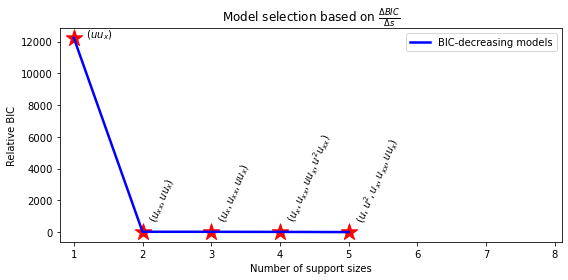

In [26]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(complexities, relative_decreasing_aics, color='blue', linewidth=2.5, label="BIC-decreasing models")
ax.scatter(complexities, relative_decreasing_aics, marker='*', c='red', s=300)
for com, name, rel_aic in zip(complexities, eff_feature_names, relative_decreasing_aics):
    rotation = (90+45)/2
    if com == 1: rotation = 0
    ax.annotate(f"    $({','.join(name)})$", (com, rel_aic), rotation=rotation)
plt.xlim(0.8,8.1)
plt.title(r"Model selection based on $\frac{\Delta BIC}{\Delta s}$")
plt.ylabel("Relative BIC")
plt.xlabel("Number of support sizes")
plt.legend()
plt.tight_layout()
# plt.savefig(join_path(FIGURE_EXPORT_PATH, "aic_model_selection.png"), dpi=300)
plt.show()

In [20]:
good_coms = set()
min_pok = 0.01
max_pok = 1./2
delta_pok = min_pok
for p in np.arange(min_pok, max_pok+delta_pok, delta_pok):
    c = find_transition_V5(decreasing_aics, complexities, percent_ok=p)
    if c == 1: break
    good_coms.add(c)
good_coms

2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percen

{2}

In [21]:
# -12216.134372396475
print(smoother_name, n_components)
print(decreasing_aics[1]-decreasing_aics[0])
decreasing_aics, complexities, eff_feature_names

none 32
-12216.134372396475


(array([-65223.31323032, -77439.44760272, -77441.58266899, -77447.20457263,
        -77459.16716993]),
 array([1, 2, 3, 4, 5]),
 [['uu_{x}'],
  ['u_{xx}', 'uu_{x}'],
  ['u_{x}', 'u_{xx}', 'uu_{x}'],
  ['u_{x}', 'u_{xx}', 'uu_{x}', 'u^2u_{xx}'],
  ['u', 'u^2', 'u_{x}', 'u_{xx}', 'uu_{x}']])

In [22]:
# np.allclose(X_pre, h5file('./IPI_output_files/PMS_data.h5')[0]) and \
# np.allclose(y_pre, h5file('./IPI_output_files/PMS_data.h5')[-1])
# np.save('./IPI_output_files/X_pre.npy', X_pre); np.save('./IPI_output_files/y_pre.npy', y_pre)

In [23]:
from sklearn.linear_model import ARDRegression

In [24]:
lam = 1e2
ard_uncerts = []
while lam < 1e7:
    ard = ARDRegression(threshold_lambda=lam, compute_score=True)
    ard.fit(X_pre, y_pre)
    ard_nonzero_indices = tuple(np.nonzero(ard.coef_)[0])
    print(ard_nonzero_indices)
    ard_uncerts.append(np.sqrt(np.diag(ard.sigma_)).sum()/np.abs(ard.coef_).sum())
    if len(ard_nonzero_indices) == X_pre.shape[-1]:
        break
    else:
        lam  = lam*5

(4,)
(3, 4)
(3, 4, 6, 7)
(1, 2, 3, 4, 6, 7)
(0, 1, 2, 3, 4, 5, 6, 7)


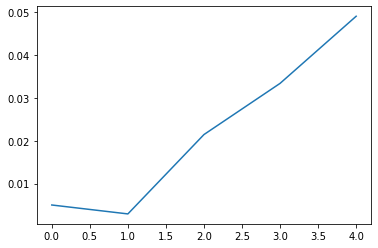

In [25]:
plt.plot(ard_uncerts); plt.show()

#### More model selection

In [21]:
# Use PDE_FIND_Loss from parametric_pde_find.py by formulating as a parametric problem
# Moving horizon in time

def ssr2llf(ssr, nobs):
    nobs2 = nobs / 2.0
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    ssr = np.sum(np.abs(ground - prediction)**2)
    return ssr2llf(ssr, nobs)

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

def AIC_Loss(A,b,x,epsilon=1e-5):
    N = A.shape[0]
    k = np.count_nonzero(x)
    # Rudy et al., 2019
    rss = ((b-A.dot(x))**2).sum()
    aic = N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
    return aic

def PDE_FIND_Loss(As,bs,x,epsilon=1e-5,const_coeff=True,cv=0,ic_type="bic",version=0):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    
    rss = [np.linalg.norm(bs[j] - As[j].dot(x[:,j].reshape(D,1)))**2 for j in range(m)]
    rss = np.sum(rss)
    llf = ssr2llf(rss, N)
    
    k = np.count_nonzero(x)
    if const_coeff:
        k = np.count_nonzero(x)/m
    k = k + k*cv
    
    if ic_type == "aic":
        aic1 = N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
        aic2 = -2*llf + 2*k + (2*k**2+2*k)/(N-k-1)
        if version > 0:
            return aic2
        return aic1
    elif ic_type == "bic":
        bic1 = N*np.log(rss/N+epsilon) + np.log(N)*k
        bic2 = -2*llf + np.log(N)*k
        if version > 0:
            return bic2
        return bic1

#### Consider uncert from BayesianRidge (brr)

[  4.748106     3.26010445  10.55670157  13.62314075  20.22593841
  35.18327326  55.42213097 118.64914745]
2,2,2,2,2,2,2,2,2,

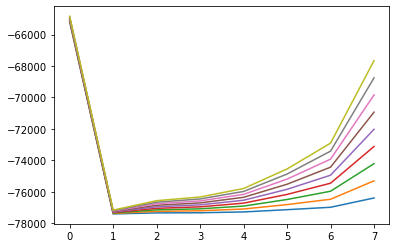

In [22]:
# baye_alpha = 1e-6
# mul_val = 1
# brr_uncertainties = []
# brr_bics = []
# for com in sorted(st.track.keys()):
#     brr = BayesianRidge(compute_score=True, alpha_1=baye_alpha, alpha_2=baye_alpha)
#     brr.fit(X_pre[:, st.track[com][0]], y_pre)
#     _, prediction_std = brr.predict(X_pre[:, st.track[com][0]], return_std=True)
#     uncert = np.trace(np.sqrt(brr.sigma_))
#     uncert = np.sqrt(np.diag(brr.sigma_)).sum()
#     brr_uncertainties.append(uncert)
#     brr_bics.append((brr.predict(X_pre[:, st.track[com][0]]).reshape(-1, 1), 
#                      np.count_nonzero(brr.coef_), 
#                      uncert))
    
# brr_uncertainties = np.array(brr_uncertainties)
# mul_val = 1/brr_uncertainties.min()
# print(brr_uncertainties*mul_val)

# for kkk in range(1, 10):
#     brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+kkk*mul_val*brr_uncert)[0] 
#                    for brr_pred, brr_com, brr_uncert in brr_bics]
#     print(np.argmin(brr_bicaics)+1, end=',')
#     plt.plot([i+1 for i in range(len(brr_bicaics))], brr_bicaics)
# plt.show()

baye_alpha = 1e-6
mul_val = 1
brr_uncertainties = []
brr_bics = []
for com in sorted(st.track.keys()):
    brr = BayesianRidge(compute_score=True, alpha_1=baye_alpha, alpha_2=baye_alpha)
    brr.fit(X_pre[:, st.track[com][0]], y_pre)
    uncert = mul_val*np.trace(np.sqrt(brr.sigma_))
    brr_uncertainties.append(uncert)
    brr_bics.append((brr.predict(X_pre[:, st.track[com][0]]).reshape(-1, 1), 
                     np.count_nonzero(brr.coef_), 
                     uncert))
brr_uncertainties = np.array(brr_uncertainties)

power = 0
while 1:
    e = brr_uncertainties.min()*(10**power)
    if e > 1: break
    power += 1
mul_val = 10**power
brr_uncertainties = brr_uncertainties*mul_val
print(brr_uncertainties)

for kkk in range(1, 10):
    brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+kkk*mul_val*brr_uncert)[0] 
                   for brr_pred, brr_com, brr_uncert in brr_bics]
    print(np.argmin(brr_bicaics)+1, end=',')
    plt.plot(brr_bicaics)
plt.show()

In [23]:
### useful for checking whether it worth having function coefficienst or not? ###
# diff_lib = ps.PDELibrary(library_functions=library_functions, 
#                          function_names=library_function_names, 
#                          derivative_order=2, 
#                          spatial_grid=x, 
#                          is_uniform=True, 
#                          differentiation_method=ps., 
#                          differentiation_kwargs=differentiation_kwargs)

diff_lib = ps.PDELibrary(library_functions=library_functions, 
                         function_names=library_function_names, 
                         derivative_order=2, 
                         spatial_grid=x, 
                         is_uniform=True, 
                         differentiation_method=differentiation_method, 
                         differentiation_kwargs=differentiation_kwargs)

candidate_lib = diff_lib.fit_transform(np.expand_dims(un[:, :], -1))
f_candidate_lib = np.stack([np.fft.fft2(candidate_lib[:, :, i]) 
                            for i in range(candidate_lib.shape[-1])], axis=-1)
candidate_lib = candidate_lib.reshape(-1, candidate_lib.shape[-1])
dynamics = diff_lib.differentiation_method(**diff_lib.differentiation_kwargs, 
                                           axis=1)._differentiate(un[:, :], 
                                                                  t)
f_dynamics = np.fft.fft2(dynamics)
dynamics = dynamics.reshape(-1,1)

dependent = "temporal"
Theta_grouped, Ut_grouped = spatial_temporal_group(candidate_lib, dynamics, 
                                                   (len(x), len(t)), 
                                                   dependent=dependent)

com2coeff = {}
com2paracoeff = {}
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    paracoeff = np.zeros(shape=(candidate_lib.shape[-1], len(Theta_grouped)))
    
    paracoeff[list(indices)] = np.hstack([np.linalg.lstsq(Theta_grouped[_][:, indices], 
                                                          Ut_grouped[_], 
                                                          rcond=None)[0] for _ in range(len(Theta_grouped))])
    
    coeff = np.zeros(shape=(candidate_lib.shape[-1], 1))
    coeff[list(indices)] = np.linalg.lstsq(candidate_lib[:, indices], dynamics)[0]
    coeff = np.hstack([coeff for _ in range(len(Theta_grouped))])
    
    com2coeff[com] = coeff
    com2paracoeff[com] = paracoeff

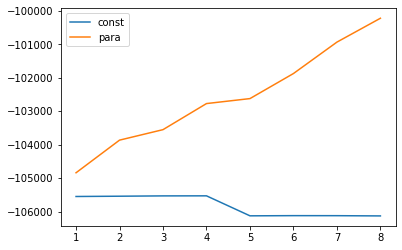

In [24]:
PDE_Losses = np.array([PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2coeff[com])
                       for com in sorted(st.track.keys())])
paraPDE_Losses = np.array([PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2paracoeff[com], const_coeff=False)
                       for com in sorted(st.track.keys())])

### decide whether you are dealing with functional coefficients here ###
plt.plot(sorted(st.track.keys()), PDE_Losses, label='const')
plt.plot(sorted(st.track.keys()), paraPDE_Losses, label='para')
plt.legend()
plt.show()

-0.006727176283387018


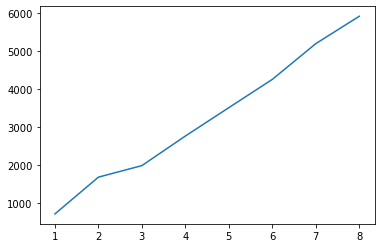

In [25]:
# 5 to 10 percent as threshold
print(np.min(paraPDE_Losses-PDE_Losses)/PDE_Losses[np.argmin(paraPDE_Losses-PDE_Losses)])
plt.plot(sorted(st.track.keys()), paraPDE_Losses-PDE_Losses)
plt.show()

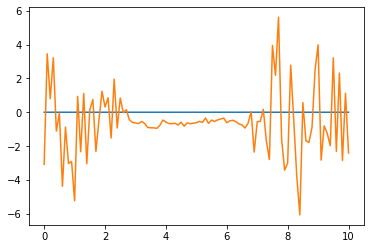

In [26]:
if dependent == "temporal":
    plt.plot(t, com2paracoeff[2][list(st.track[2][0])][0])
    plt.plot(t, com2paracoeff[2][list(st.track[2][0])][1])
elif dependent == "spatial":
    plt.plot(x, com2paracoeff[2][list(st.track[2][0])][0])
    plt.plot(x, com2paracoeff[2][list(st.track[2][0])][1])
plt.show()

In [27]:
maxi = np.max(t); mini = np.min(t)
mid = (mini+maxi)/2
ss = np.arange(0, len(t)-(list(t).index(mid)), dtype=np.int)

com2coeff_sub = {}
for s in ss:
    t_sub_indices = [i+s for i in range(list(t).index(mid)+1)]
    t_sub = t[t_sub_indices]
    un_sub = (un.copy())[:, t_sub_indices]
    print(t_sub_indices[0], "->", t_sub_indices[-1])

    diff_lib = ps.PDELibrary(library_functions=library_functions, 
                             function_names=library_function_names, 
                             derivative_order=2, 
                             spatial_grid=x, 
                             is_uniform=True, 
                             differentiation_method=ps.SmoothedFiniteDifference, 
                             differentiation_kwargs=differentiation_kwargs)

    candidate_lib_sub = diff_lib.fit_transform(np.expand_dims(un_sub, -1))
    candidate_lib_sub = candidate_lib_sub.reshape(-1, candidate_lib_sub.shape[-1])
    dynamics_sub = diff_lib.differentiation_method(**diff_lib.differentiation_kwargs, 
                                                   axis=1)._differentiate(un_sub, 
                                                                          t_sub).reshape(-1,1)
    
    Theta_grouped_sub, Ut_grouped_sub = spatial_temporal_group(candidate_lib_sub, dynamics_sub, 
                                                               (len(x), len(t_sub)), 
                                                               dependent=dependent)
    
    for com in sorted(st.track.keys()):
        indices, _ = st.track[com]
        
        coeff = np.hstack([np.linalg.lstsq(Theta_grouped_sub[_][:, indices], 
                                           Ut_grouped_sub[_], 
                                           rcond=None)[0] for _ in range(len(Theta_grouped_sub))])

#         coeff = np.zeros(shape=(candidate_lib_sub.shape[-1], 1))
#         coeff[list(indices)] = np.linalg.lstsq(candidate_lib_sub[:, indices], dynamics_sub)[0]
#         coeff = np.hstack([coeff for _ in range(n)])

        coeff = np.expand_dims(coeff, 0)
        if com not in com2coeff_sub: 
            com2coeff_sub[com] = coeff
        else: 
            com2coeff_sub[com] = np.vstack((com2coeff_sub[com], coeff))

0 -> 50
1 -> 51
2 -> 52
3 -> 53
4 -> 54
5 -> 55
6 -> 56
7 -> 57
8 -> 58
9 -> 59
10 -> 60
11 -> 61
12 -> 62
13 -> 63
14 -> 64
15 -> 65
16 -> 66
17 -> 67
18 -> 68
19 -> 69
20 -> 70
21 -> 71
22 -> 72
23 -> 73
24 -> 74
25 -> 75
26 -> 76
27 -> 77
28 -> 78
29 -> 79
30 -> 80
31 -> 81
32 -> 82
33 -> 83
34 -> 84
35 -> 85
36 -> 86
37 -> 87
38 -> 88
39 -> 89
40 -> 90
41 -> 91
42 -> 92
43 -> 93
44 -> 94
45 -> 95
46 -> 96
47 -> 97
48 -> 98
49 -> 99
50 -> 100


In [28]:
# cvs = np.zeros((len(st.track.keys()), len(diff_lib.get_feature_names())))
# for com in sorted(st.track.keys()):
#     indices, _ = st.track[com]
#     cv_com = np.zeros(len(diff_lib.get_feature_names()))
    
#     ### treat a seq of coeff values in one horizon as a mean constant number ###
#     mh_coeffs = np.mean(com2coeff_sub[com], axis=-1)
#     cv = np.std(mh_coeffs, axis=0)/np.mean(mh_coeffs, axis=0)
#     cv = cv[~np.isnan(cv)]
#     cv_com[list(indices)] = np.abs(cv)
    
#     ### mean over the horizon axis as well
#     # cv = np.abs(com2coeff_sub[com].std(axis=0)/com2coeff_sub[com].mean(axis=0)).mean(axis=-1)
#     # cv = cv[~np.isnan(cv)]
    
#     cv_com[list(indices)] = np.abs(cv)
#     cvs[com-1] = cv_com

# cvs.sum(axis=-1)

cvs = np.zeros((len(st.track.keys()), len(diff_lib.get_feature_names())))
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    cv_com = np.zeros(len(diff_lib.get_feature_names()))
    
    ### treat a seq of coeff values in one horizon as a mean constant number ###
    mh_coeffs = np.mean(com2coeff_sub[com], axis=-1)
    cv_com[list(indices)] = np.abs(np.std(mh_coeffs, axis=0)/np.mean(mh_coeffs, axis=0))
    
    ### mean over the horizon axis as well
    # cv_com[list(indices)] = np.abs(com2coeff_sub[com].std(axis=0)/com2coeff_sub[com].mean(axis=0)).mean(axis=-1)
    
    cvs[com-1] = cv_com
    
cvs.sum(axis=-1)

array([ 0.9124344 ,  1.4843716 , 47.92320231, 10.71686891,  8.08162916,
        9.22558612, 11.21813619, 21.91316652])

2


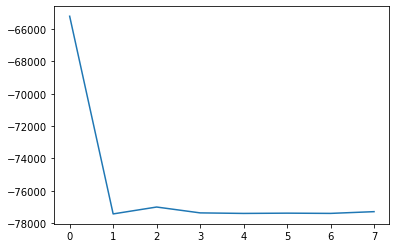

In [29]:
brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+cvs.sum(axis=-1)[brr_com-1])[0] 
               for brr_pred, brr_com, brr_uncert in brr_bics]
print(np.argmin(brr_bicaics)+1)
plt.plot(brr_bicaics)
plt.show()

#### Denoised weak form: Tune (p, q), ws

In [30]:
def weight_poly(x, m, k):
    """
    Polynomial piece of weighting function used to satisfy BC A = d^k/dx^k[(x^2 - 1)^m]
    x: independent variable
    m: power of base function
    k: order of derivative
    """
    a = np.zeros((2*m+1, 1)) # initial coefficient vector
    for l in range(m+1):
        a[2*l] = ((-1)**(m-l))*np.math.comb(m, l) # set polynomial coefficients
    
    c = np.zeros((2*m+1, 1)) # final coefficient vector
    for n in range(2*m-k+1):
        c[n] = a[n+k]*np.math.factorial(n+k)/np.math.factorial(n)
    
    p = 0
    for n in range(2*m-k+1):
        p += c[n]*(x**n) # final windowing function

    return p

def weight_full(k, p, x, t):
    """
    Assemble the 1D weight functions into the full weight
    k = [kx,ky,kt]: order of derivative(s)
    p = [px,py,pt]: exponents of weight polynomials
    """
    if len(k) == 3:
        wx = weight_poly(x, p[0], k[0])
        wy = weight_poly(x, p[1], k[1])
        wt = weight_poly(t, p[2], k[2])
        wX, wY, wT = np.meshgrid(wx, wy, wt)
        W = wX * wY * wT
    elif len(k) == 2:
        wx = weight_poly(x, p[0], k[0])
        wt = weight_poly(t, p[1], k[1])
        wT, wX = np.meshgrid(wt, wx)
        W = wX * wT
    
    return W, wx, wt

In [31]:
u_weak = un.copy()
n_domain = 10000
div = 3.5
x_size, t_size = int(max(u_weak.shape)/div), int(max(u_weak.shape)/div)

xsup = np.linspace(-1,1,x_size+1)
tsup = np.linspace(-1,1,t_size+1)
S_x = 2/(dx*x_size)
S_t = 2/(dt*t_size)

In [32]:
max_order = 2
best_loss = 1e6; best_coeff = None
for mo in range(max_order, max_order+10, 1):
    wx, wt = np.meshgrid((xsup**2-1)**(mo), (tsup**2-1)**(mo))
    W = (wx*wt).T
    
    # Define the derivative:
    d_dx = FinDiff(0, xsup[1]-xsup[0], 1)
    d_dxx = FinDiff(0, xsup[1]-xsup[0], 2)
    d_dxxxx = FinDiff(0, xsup[1]-xsup[0], 4)
    d_dt = FinDiff(1, tsup[1]-tsup[0], 1)

    dA01 = d_dt(W)
    dA10 = d_dx(W)
    dA20 = d_dxx(W)
    dA40 = d_dxxxx(W)

    X_weak = []
    y_weak = []
    for _ in trange(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)

        usup = (u_weak[ix, :][:, it])

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, dt, 1), xsup, dx, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, dt, 1), xsup, dx, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, dt, 1), xsup, dx, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)

    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()

    print(mo)
    print(loss, evaluate_coefficients(coeff))
    if loss < best_loss:
        best_loss = loss
        best_coeff = coeff
    else:
        break

best_mo = mo-1
best_coeff, evaluate_coefficients(best_coeff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4679.23it/s]


2
1.7552590731811562e-07 (0.077948920306177, 0.022922745322502547)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4673.26it/s]

3
1.7648970114190082e-07 (0.07372218717927315, 0.020172830046491508)


(array([ 0.10010087, -1.00055026]), (0.077948920306177, 0.022922745322502547))

#### Savgol_filter

In [33]:
wx, wt = np.meshgrid((xsup**2-1)**(best_mo), (tsup**2-1)**(best_mo))
W = (wx*wt).T

# Define the derivative:
d_dx = FinDiff(0, xsup[1]-xsup[0], 1, acc=4)
d_dxx = FinDiff(0, xsup[1]-xsup[0], 2, acc=4)
d_dxxxx = FinDiff(0, xsup[1]-xsup[0], 4, acc=4)
d_dt = FinDiff(1, tsup[1]-tsup[0], 1, acc=4)

dA01 = d_dt(W)
dA10 = d_dx(W)
dA20 = d_dxx(W)
dA40 = d_dxxxx(W)

min_loss = 1e6; best_coeff = None
for ws in trange(3, 33, 2):
    X_weak = []
    y_weak = []
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = savgol_filter(u_weak[ix, :][:, it], ws, 2)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, 1), xsup, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, 1), xsup, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, 1), xsup, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff

# (0.03524781993990561, 0.011424239600747732)
min_loss, best_coeff, evaluate_coefficients(best_coeff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:30<00:00,  6.01s/it]


(1.7265632105282138e-07,
 array([ 0.09997618, -1.00046672]),
 (0.03524781993990561, 0.011424239600747732))

#### wiener

In [34]:
min_loss = 1e6; best_coeff = None
for ws in trange(3, 33, 1):
    X_weak = []
    y_weak = []
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = wiener(u_weak[ix, :][:, it], ws)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, 1), xsup, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, 1), xsup, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, 1), xsup, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff

# (0.4346650845124686, 0.23677533103052956)
min_loss, best_coeff, evaluate_coefficients(best_coeff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [04:55<00:00,  9.86s/it]


(1.5584447161133684e-07,
 array([ 0.10067144, -1.0019789 ]),
 (0.4346650845124686, 0.23677533103052956))

In [35]:
raise SystemExit("Stop right here!")

SystemExit: Stop right here!

#### Save

In [ ]:
best_subsets = sorted([indices for _, (indices, _) in st.track.items()], key=lambda _: len(_))
tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))
for i in range(len(best_subsets)):
    tmp[i:i+1, :][0, best_subsets[i]] = 1.0
best_subsets = tmp.astype(np.float32)
del tmp

pms_data = {nameof(un): un, 
            nameof(X_pre): X_pre, 
            nameof(y_pre): y_pre, 
            nameof(best_subsets): best_subsets}
pms_data

In [ ]:
basic_vars = {'u'}
encoded_feature_names = []
for feature in model.get_feature_names():
    out_feature = []
    last_index = -1
    for i, c in enumerate(feature):
        if i+1 < len(feature) and feature[i+1] in basic_vars:
            last_index = i
            out_feature.append(c+'*')
    out_feature.append(feature[last_index+1:])
    encoded_feature_names.append(''.join(out_feature))
encoded_feature_names = np.array(encoded_feature_names)
encoded_feature_names.tolist()

In [ ]:
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    expr = '+'.join(encoded_feature_names[list(indices)])
    print(expr)
    print('----------')
encoded_pde_names = ['+'.join(encoded_feature_names[list(indices)]) for _, (indices, _) 
                     in sorted(st.track.items())]

In [ ]:
import yaml
from omegaconf import OmegaConf
yml = {}
yml["encoded_feature_names"] = encoded_feature_names.tolist()
yml["encoded_pde_names"] = encoded_pde_names
yml["information_criterion_score"] = [float(ic) for _, (_, ic) in st.track.items()]

#### Save files for training PINNs & DeepONets

In [ ]:
fp1 = "../Burgers_exp/IPI_output_files/PMS_data.h5"
fp2 = "../Burgers_exp/IPI_output_files/encoded_pde_names.yaml"
fp1, fp2

In [ ]:
h5file(file_path=fp1, cdict=pms_data, mode='w')
OmegaConf.save(config=OmegaConf.create(yml), f=fp2)

In [ ]:
OmegaConf.load(fp2)

In [ ]:
h5file(file_path=fp1, mode='r', return_dict=False)